In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

import matplotlib.pyplot as plt


import pandas as pd
import pickle
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'sklearn'

In [2]:
# Reading in the cleaned dataset
delay_df = pd.read_pickle("combined_flight_data")

In [78]:
# Restrictng dataset to data with a delay
#delay_df = delay_df[delay_df.ArrDelay > 5]

In [3]:
# Extracting target delay data column from the dataset
delayed = delay_df[['ArrDel15']]
delay_df = delay_df.drop("ArrDel15",axis=1)

In [4]:
# Dropping all columns directly related to the target variable
delay_df = delay_df.drop(['DepTime', 'DepDelay', 'DepDelayMinutes',
       'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut',
       'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay',
       'ArrDelayMinutes', 'ArrivalDelayGroups', 'ArrTimeBlk',
       'Cancelled', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime',
       'AirTime', 'DivAirportLandings',
       'Duplicate', 'Unnamed: 0'], axis=1)

In [5]:
delay_df.columns

Index(['index', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'FlightDate', 'Marketing_Airline_Network',
       'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline',
       'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline',
       'Operating_Airline ', 'DOT_ID_Operating_Airline',
       'IATA_Code_Operating_Airline', 'Tail_Number',
       'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest',
       'DestCityName', 'DestState', 'DestStateFips', 'DestStateName',
       'DestWac', 'CRSDepTime', 'Flights', 'Distance', 'DistanceGroup',
       'obs_id', 'obs_name', 'valid_time_gmt', 'expire_time_gmt', 'day_ind',
       'temp', 'dewPt', 'rh', 'wdir_cardinal', 'gust', 'wspd', 'pressure',
       'precip_hrly', 'wx_phrase', 'loc

In [48]:
# Defining relevant columns and trimming the dataset down to relevant columns
relevant_flight_cols = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Distance',
                        'Origin', 'OriginCityName', 'OriginStateName', 'OriginCityMarketID',
                        'Dest', 'DestCityName', 'DestStateName', 'DestCityMarketID'
                        #,'Reporting_Airline', 'ActualElapsedTime', 'AirTime'
                        ]
relevant_weather_cols = ['temp', 'dewPt', 'wspd', 'pressure', 'precip_hrly']
relevant_columns = relevant_flight_cols + relevant_weather_cols
delay_df = delay_df[relevant_columns]

In [81]:
# Converting ID numbers to categorical string data
delay_df.OriginCityMarketID = delay_df.OriginCityMarketID.astype(str)
delay_df.DestCityMarketID = delay_df.DestCityMarketID.astype(str)

In [82]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(delay_df, delayed)

In [83]:
# Recording which columns are numeric and which are categorical
numeric_cols = X_train.dtypes[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')].index.tolist()
non_numeric_cols = X_train.dtypes[(X_train.dtypes != 'int64') & (X_train.dtypes != 'float64')].index.tolist()

In [84]:
# Creating a transformer object to scale numeric data and encode categorical data
encoder = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_cols),
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), non_numeric_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [85]:
# Applying pre-processing transformations
encoder.fit(X_train)
X_train_sparse = encoder.transform(X_train)
X_train_columns = encoder.get_feature_names_out()
X_test_sparse = encoder.transform(X_test)
X_test_columns = encoder.get_feature_names_out()

C:\Users\bruno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [6, 19, 20, 32, 39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [86]:
# Defining logistic regression parameters to sweep over
logreg_params = {
    'penalty':['l1','l2'],
    'C':[0.1,1,10]
}
# GridSearching logistic regression classifiers
logreg_grid = GridSearchCV(LogisticRegression(solver='liblinear'), logreg_params, n_jobs=-2)
logreg_grid.fit(X_train_sparse, np.ravel(y_train))
# Printing out train and test accuracy scores
print(f'Training accuracy: {logreg_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {logreg_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.8325817031744173
Testing accuracy: 0.8352806817183519


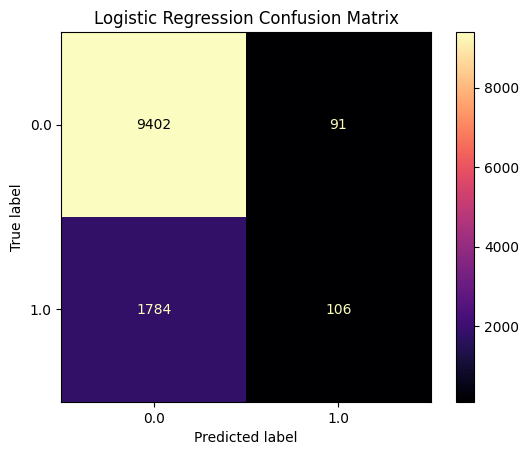

In [87]:
ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test_sparse, y_test, cmap='magma');
plt.title('Logistic Regression Confusion Matrix');

In [88]:
# Defining random forest parameters to sweep over
rfc_params = {
    'n_estimators':[100,1000],
    'max_depth':[100,1000],
    'ccp_alpha':[0, 0.1]
}
# GridSearching random forest classifiers
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, n_jobs=-2)
rfc_grid.fit(X_train_sparse, y_train)
# Displaying train and test scores
print(f'Training accuracy: {rfc_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {rfc_grid.score(X_test_sparse, y_test)}')

KeyboardInterrupt: 

In [ ]:
ConfusionMatrixDisplay.from_estimator(rfc_grid, X_test_sparse, y_test, cmap='magma');
plt.title('Random Forest Confusion Matrix');